# Install & Import

In [1]:
# import packages
import tensorflow as tf
import numpy as np
import json
import pandas as pd
import math
import cv2
import os
import glob
from IPython.display import clear_output
import seaborn as sns

# import modules
from pycocotools.coco import COCO
from pprint import pprint
from matplotlib import pyplot as plt

# this was imported for multipose, we may not need it for our purposes
import tensorflow_hub as hub

# initialize MoveNet

In [2]:
# initialize TFLite interpreter
interpreter = tf.lite.Interpreter(model_path="lite-model_movenet_singlepose_lightning_3.tflite")

# pre-allocate tensors to the model (necessary for TFLite model)
interpreter.allocate_tensors()

In [3]:
interpreter.get_input_details()

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 192, 192,   3], dtype=int32),
  'shape_signature': array([  1, 192, 192,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [4]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 312,
  'shape': array([ 1,  1, 17,  3], dtype=int32),
  'shape_signature': array([ 1,  1, 17,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

# make MoveNet predictions

- 17 keypoints (in the order of: **[nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle]**)
- **Note: model output is y,x not x,y**

In [5]:
# single video predictions

def movenet_single_vid(path):

    # create connection to single video
    cap = cv2.VideoCapture(path)
    output = []

    while cap.isOpened(): #while connection is open
        ret, frame = cap.read() #read frame by frame

        # break while loop once no more frames
        if frame is None:
            break

        # Reshape image
        img = frame.copy()
        # add an extra dimension along axis 0 TO resize with pad 
        img = tf.image.resize(np.expand_dims(img, axis=0), (192,192))
        # re-cast tensor as float32 as this is the type that the model requires as input
        input_image = tf.cast(img, dtype=tf.float32) 

        # fetch input and output details from TFLite interpreter
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # MAKE PREDICTIONS
        # setting input details equal to input image
        interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
        # get predictions
        interpreter.invoke() 
        # creating output variable from 'index' in output_details
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index']) 
        # store keypoints in output list
        output.append(np.array(np.squeeze(keypoints_with_scores)))

    cap.release()
    
    output_denorm = []
    
    # denormalise output
    for frame in output:
        output_denorm.append(np.array(frame*([192,192,1])))
    
    # convert output to integer
    output_denorm_int = np.array(output_denorm).astype(int)
    
    return np.array(output_denorm_int)

path = "000002.mp4"
test_path = 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0/000027.mp4'
output = movenet_single_vid(path)

print('Output Shape \n', output.shape, '\n')
print('Example Frame Output (x,y,conf): \n', 'NB. Model output is y,x not x,y \n' ,output[0])

2023-01-08 11:48:48.974908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Output Shape 
 (278, 17, 3) 

Example Frame Output (x,y,conf): 
 NB. Model output is y,x not x,y 
 [[154 110   0]
 [153 110   0]
 [160 130   0]
 [160 122   0]
 [165 145   0]
 [ 97 109   0]
 [ 97  96   0]
 [ 95 119   0]
 [ 98  88   0]
 [141 118   0]
 [ 96  84   0]
 [113 101   0]
 [112  91   0]
 [119  84   0]
 [118  80   0]
 [143  61   0]
 [143  74   0]]


In [6]:
# make predictions for ALL videos

def movenet_folders(path):
    
    paths = {}
    folders_kp_pred = {}
    
    # list of sub-folders "infinityai_fitness_basic_***_v1.0" in folder "InfinityAI Data"
    folders = glob.glob(path+'/infinityai_fitness_basic_*_v1.0', recursive = True)
    folder_count = len(folders)
    
    # print sub-folders found
    print(folder_count, "folders found")
    pprint(folders)
    
    # list of files in subfolder "***.mp4"
    for folder in folders:
        
        # instantiate empty list for each sub-folder
        paths[folder] = []
        
        # list of paths for each file in sub-folder
        files = sorted(glob.glob(folder+'/*.mp4', recursive = True))
        
        # store list of pathnames for files
        paths[folder] = files
        
        # isolate exercise name
        ex_name = folder.split("_")[-2]
        
        folders_kp_pred[ex_name] = {}
        
        #iterate through files in current folder
        for ind_file, file in enumerate(paths[folder]):
            
            # extract video number
            vid_num = file.split("/")[-1]
            vid_num = str(vid_num.split(".")[0])
            
            # predict frame keypoints with selected model
            video_kp_pred = movenet_single_vid(file)
            
            # append dictionary with video kp predictions per frame
            folders_kp_pred[ex_name][vid_num] = list(video_kp_pred)
            
            print("VIDEO COMPLETE:", ex_name, vid_num)
            
        print("!!! FOLDER COMPLETE: ", ex_name)
    
    print("___ALL FOLDERS COMPLETE___")
    
    return folders_kp_pred

path = "InfinityAI Data"
test_directory = "Test Files"

# folders_kp_pred_test = movenet_folders(test_directory)
folders_kp_pred = movenet_folders(path)

10 folders found
['InfinityAI Data/infinityai_fitness_basic_curl_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
VIDEO COMPLETE: curl 000000
VIDEO COMPLETE: curl 000001
VIDEO COMPLETE: curl 000002
VIDEO COMPLETE: curl 000003
VIDEO COMPLETE: curl 000004
VIDEO COMPLETE: curl 000005
VIDEO COMPLETE: curl 000006
VIDEO COMPLETE: curl 000007
VIDEO COMPLETE: curl 000008
VIDEO COMPLETE: curl 000009
VIDEO COMPLETE: curl 000010
VIDEO COMPLETE: curl 000011
VIDEO COMPLETE: curl 000012
VIDEO COMPLETE: curl 000013
VIDEO 

# Notes

In [7]:
# example frame extraction from prediction dictionary
pprint(folders_kp_pred['armraise']['000000'][0])

array([[ 84, 122,   0],
       [ 82, 121,   0],
       [ 82, 122,   0],
       [ 83, 121,   0],
       [ 83, 121,   0],
       [ 93, 119,   0],
       [ 93, 125,   0],
       [106, 120,   0],
       [106, 126,   0],
       [115, 124,   0],
       [115, 122,   0],
       [115, 121,   0],
       [115, 122,   0],
       [132, 123,   0],
       [132, 119,   0],
       [151, 124,   0],
       [151, 117,   0]])


- folders (n) ex_names
- videos (n) vid_no
- frames (n) fra_no
- kps (17) kp_no / kp_name
- xyz (3) x,y,z

# single video: extract annotations from JSON: kp preds, bbox coordinates & calculate torso diameter

JSON labels: The COCO bounding box format is **[top left x position, top left y position, width, height]**.

MN Pred: The first two channels of the last dimension represents the yx coordinates (normalized to image frame, i.e. range in [0.0, 1.0]) of the 17 keypoints (in the order of: [[0]nose, [1]left eye, [2]right eye, [3]left ear, [4]right ear, [5]left shoulder, [6]right shoulder, [7]left elbow, [8]right elbow, [9]left wrist, [10]right wrist, [11]left hip, [12]right hip, [13]left knee, [14]right knee, [15]left ankle, [16]right ankle]).

In [27]:
# create list of video bbox coordinates per frame

json_path = '000002.json'
json_path_error = 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0/000027.json'

def json_single(json_path):
    
    coco = COCO(json_path)
    
    bbox_true_per_frame = []

    for img_data in coco.imgs.values():
        img_id = img_data["id"]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        for ann in anns:
            
            # skip non-person instances
            if ann["category_id"] != 0:
                continue
            frame_bbox = ann["bbox"]
            bbox_true_per_frame.append(frame_bbox)

    keypoints_true_per_frame = []
    torso_diam_per_frame = []

    for img_data in coco.imgs.values():
        img_id = img_data["id"]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        for ann in anns:
            
            # skip non-person instances
            if ann["category_id"] != 0:
                continue
            keypoints = np.array(ann["keypoints"])
            keypoints = np.reshape(keypoints, (17, 3))
            keypoints_true_per_frame.append(keypoints)
            
            # calculate frame 'torso diameter'
            right_hip = keypoints[12][:2]
            left_shoul = keypoints[5][:2]
            
            x = abs(right_hip[0] - left_shoul[0])
            y = abs(right_hip[1] - left_shoul[1])
            
            torso_diam_single_frame = np.sqrt( (x)**2 + (y)**2 )
            torso_diam_per_frame.append(torso_diam_single_frame)
    
    return bbox_true_per_frame, keypoints_true_per_frame, torso_diam_per_frame

true_bbox, true_anns, torso_diam = json_single(json_path)

print('bbox COCO format \n', true_bbox[0], '\n')
print('bbox labels shape \n', (np.array(true_bbox)).shape, '\n')
print('anns \n', true_anns[0], '\n')
print('frame labels shape\n', true_anns[0].shape, '\n')
print('video labels shape\n', (np.array(true_anns)).shape, '\n')
print('tors_diam \n', torso_diam[0], '\n')

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
bbox COCO format 
 [132.01, 153.01, 27.980000000000018, 11.980000000000018] 

bbox labels shape 
 (278, 4) 

anns 
 [[157 163   1]
 [155 160   1]
 [153 160   1]
 [  0   0   0]
 [  0   0   0]
 [161 170   1]
 [147 171   1]
 [159 168   1]
 [134 169   1]
 [159 160   1]
 [141 159   1]
 [151 181   1]
 [138 179   1]
 [145 178   1]
 [139 157   2]
 [136 192   1]
 [138 165   1]] 

frame labels shape
 (17, 3) 

video labels shape
 (278, 17, 3) 

tors_diam 
 24.698178070456937 



# calculate accuracy threshold

- either PDJ with 'torso diameter', or PCKh with 'bone head link'
- can calculate PDJ, can't calculate PCKh
- however, prefer PCKh over PDJ - dilemma - as it is more accuarate and more commonly used in literature

- therefore, can use PDJ and justify - best to confirm with Lina first
- or, can find out if head box possible (this might be answered by Lina, should I ask Eric?)
- also, 

# PDJ (error using torso diameter)
## 1. calculate error between predicted and label
## 2. compare error to torso diameter

Image coordinates (x,y), visibility (v), and depth from camera (z, in meters) for each degree-of-freedom in the underlying SMPL-X model. Visibility values indicate whether keypoints are outside the image frame and not occluded from view (0), inside or outside the image frame and occluded from view (1), or **inside the image frame and not occluded from view (2)**. Note: keypoints that are outside the image frame will have x/y values outside the image dimensions.

In [28]:
# determine frame PDJ based on all keypoints
def PDJ_all_kp(frame_kp_labels, frame_kp_pred, threshold, frame_torso_diam):
    
    kp_acc = []
    
    for kp_ind, kp in enumerate(frame_kp_labels):

        # x distance
        kp_dist_x = abs( frame_kp_pred[kp_ind][1] - frame_kp_labels[kp_ind][0] )
        # y distance
        kp_dist_y = abs( frame_kp_pred[kp_ind][0] - frame_kp_labels[kp_ind][1] )
        # z distance
        kp_dist = math.sqrt( (kp_dist_x)**2 + (kp_dist_y)**2 )

        # record distance for each keypoint, for each frame
        kp_acc.append(kp_dist)

        # record whether distance is above or below threshold (predicted or not)
        kp_acc.append( bool(kp_dist < threshold*frame_torso_diam) )
    
    half_len = int((len(kp_acc) / 2)) 
    kp_acc = np.reshape(np.array(kp_acc), (half_len ,2))
    
    return kp_acc


# determine frame PDJ based on visibility choice
def PDJ_vis_kp(frame_kp_labels, frame_kp_pred, visibility, threshold, frame_torso_diam):
    
    kp_acc = []
    
    for kp_ind, kp in enumerate(frame_kp_labels):
        
        if kp[2] == visibility:

            # x distance
            kp_dist_x = abs( frame_kp_pred[kp_ind][1] - frame_kp_labels[kp_ind][0] )
            # y distance
            kp_dist_y = abs( frame_kp_pred[kp_ind][0] - frame_kp_labels[kp_ind][1] )
            # z distance
            kp_dist = math.sqrt( (kp_dist_x)**2 + (kp_dist_y)**2 )

            # record distance for each keypoint, for each frame
            kp_acc.append(kp_dist)

            # record whether distance is above or below threshold (predicted or not)
            kp_acc.append( bool(kp_dist < threshold*frame_torso_diam) )
    
    half_len = int((len(kp_acc) / 2)) 
    kp_acc = np.reshape(np.array(kp_acc), (half_len ,2))
    
    return kp_acc


            
# for a single video: for each frame, for each keypoint, calculate euclidean difference between predicted and actual
def frame_acc(frame_kp_pred, frame_kp_labels, threshold, frame_torso_diam, visibility=None):
    
    """ visibility = None is all keypoints
        visibility = 0 is keypoints are outside the image frame and not occluded from view
        visibility = 1 is keypoints are inside or outside the image frame and occluded from view
        visibility = 2 is keypoints are inside the image frame and not occluded from view 
        visibility = a2o is, all keypoints of frame are 2 (inside the image frame and not occluded from view) """
    
    kp_acc = []
    
    # if visibility = all, calculate distance of every keypoint
    if visibility == None:
        
        kp_acc = PDJ_all_kp(frame_kp_labels, frame_kp_pred, threshold, frame_torso_diam)
        
    # if visibility = N, calculate distance at N keypoints
    elif visibility in [0, 1, 2]:
        
        kp_acc = PDJ_vis_kp(frame_kp_labels, frame_kp_pred, visibility, threshold, frame_torso_diam)
    
    """
    # a20 is frames with all 2's only
    elif visibility == 'a2o':
        
        visibility = 2
        kp_acc = PDJ_vis_kp(frame_kp_labels, frame_kp_pred, visibility, threshold, frame_torso_diam)
        
        # if len(kp_acc) = 17, continue with frame, else ignore/discard frame
        if len(kp_acc) != 17:
            return 0 """
    
    # count correctly predicted keypoints
    i = 0
    
    for kp in kp_acc:
        if kp[1] == 1:
            i += 1
        else:
            continue
    
    if len(kp_acc) > 0:
        frame_mean_accuracy = ( i / len(kp_acc) )*100

    else:
        frame_mean_accuracy = 0.0
    
    return frame_mean_accuracy

results = frame_acc(output[0], true_anns[0], 0.5, torso_diam[0], 1)

# print("shape:\n", results.shape)
print("frame acc.:\n", results)

frame acc.:
 0.0


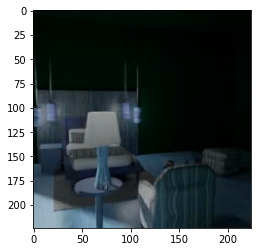

In [29]:
# Visualize single frame with labels and predictions
# [1] function which can display a single frame from a chosen video, with its predictions overlaid
# [2] same function with predictions in one color and labels in another

filename = "000002.mp4"

cap = cv2.VideoCapture(filename)
cap.set(1,0);  # (
success = cap.grab()
ret, image = cap.retrieve()
plt.figure(2)
plt.imshow(image)

# PCK (error using bounding box max side length

In [30]:
# PCK frame accuracy for visibility parameter None (all keypoints)
def pck_all_kp(frame_kp_pred, frame_kp_labels, threshold, bbox_max):
    
    kp_acc = []
    
    for kp_ind, kp in enumerate(frame_kp_labels):
            
        # diff_x = pred_x - actual_x
        kp_dist_x = abs( frame_kp_pred[kp_ind][1] - frame_kp_labels[kp_ind][0] )
        # diff_y = pred_y - actual_y
        kp_dist_y = abs( frame_kp_pred[kp_ind][0] - frame_kp_labels[kp_ind][1] )

        # distance = sqrt( x2 + y2 )
        kp_dist = math.sqrt( (kp_dist_x)**2 + (kp_dist_y)**2 )

        # record distance for each keypoint, for each frame
        kp_acc.append(kp_dist)

        # record whether distance is above or below threshold (predicted or not)
        kp_acc.append( bool(kp_dist < threshold*bbox_max) )
    
    half_len = int((len(kp_acc) / 2)) 
    kp_acc = np.reshape(np.array(kp_acc), (half_len ,2))
    
    return kp_acc
            
# PCK frame accuracy for selected visibility parameter
def pck_vis_kp(frame_kp_pred, frame_kp_labels, threshold, bbox_max, visibility):
    
    kp_acc = []
    
    for kp_ind, kp in enumerate(frame_kp_labels):
        
        ## if keypoint label is in full view, then...
        if kp[2] == visibility:
            #print('valid')

            # diff_x = pred_x - actual_x
            kp_dist_x = abs( frame_kp_pred[kp_ind][1] - frame_kp_labels[kp_ind][0] )
            # diff_y = pred_y - actual_y
            kp_dist_y = abs( frame_kp_pred[kp_ind][0] - frame_kp_labels[kp_ind][1] )

            # distance = sqrt( x2 + y2 )
            kp_dist = math.sqrt( (kp_dist_x)**2 + (kp_dist_y)**2 )

            # record distance for each keypoint, for each frame
            kp_acc.append(kp_dist)

            # record whether distance is above or below threshold (predicted or not)
            kp_acc.append( bool(kp_dist < threshold*bbox_max) )

        ## elif keypoint is not in full view, skip...
        else:
            continue
    
    half_len = int((len(kp_acc) / 2)) 
    kp_acc = np.reshape(np.array(kp_acc), (half_len ,2))
    
    return kp_acc
    
# for a single frame: calculate the accuracy using difference between predicted and actual, and bounding box max side length (PCK@1, PCK@0.5, PCK@0.25)
def frame_acc_bbox(frame_kp_pred, frame_kp_labels, threshold, true_bbox, visibility=None):
    
    #pprint('pred: ')
    #print( frame_kp_pred )
    #print('labels: ')
    #print(frame_kp_labels)
    #print('bbox: ', true_bbox )
    
    kp_acc = []
    
    bbox_w = true_bbox[2]
    bbox_h = true_bbox[3]
    
    # determine max side length of bbox (bbox_max)
    if bbox_w > bbox_h:
        bbox_max = bbox_w
    else:
        bbox_max = bbox_h
    
    #print('bbox_max: ', bbox_max)
    
    # if visibility = all, calculate distance of every keypoint
    if visibility == None:
        
        kp_acc = pck_all_kp(frame_kp_pred, frame_kp_labels, threshold, bbox_max)
    
    # if visibility = N, calculate distance at N keypoints
    elif visibility in [0, 1, 2]:
        
        kp_acc = pck_vis_kp(frame_kp_pred, frame_kp_labels, threshold, bbox_max, visibility)
    
    """
    elif visibility == 'a2o':
        
        visibility = 2
        kp_acc = pck_vis_kp(frame_kp_pred, frame_kp_labels, threshold, bbox_max, visibility)
        
        # if len(kp_acc) = 17, continue with frame, else ignore/discard frame
        if len(kp_acc) != 17:
            return 0 """
    
    i = 0
    
    for kp in kp_acc:
        if kp[1] == 1:
            i += 1
        else:
            continue
    
    if len(kp_acc) > 0:
        frame_mean_accuracy = ( i / len(kp_acc) )*100 ### <- CHECK HERE, change len(kp_diff) to half_len
    
    else:
        frame_mean_accuracy = 0
    
    return frame_mean_accuracy

results = frame_acc_bbox(output[0], true_anns[0], 1, true_bbox[0])

# print("shape:\n", results.shape)
print("frame acc.:\n", results)

frame acc.:
 5.88235294117647


# Global function

In [31]:
# function for parsing through videos in folder (model, path, threshold)

def video_folder_predictions(directory, metric, threshold, visibility=None):
    # visibility = None is ALL keypoints
    # visibility = 0 is keypoints are outside the image frame and not occluded from view
    # visibility = 1 is inside or outside the image frame and occluded from view
    # visibility = 2 is inside the image frame and not occluded from view
    
    paths = {}
    results_global_mean = []
    results_per_vid = []
    results_per_folder = []
  
    # list of sub-folders "infinityai_fitness_basic_***_v1.0" in folder "InfinityAI Data"
    folders = glob.glob(directory+'/infinityai_fitness_basic_*_v1.0', recursive = True)
    print(folders)
    
    folder_mean_acc = []
    
    # list of files in subfolder "***.mp4"
    for folder in folders:
        paths[folder] = []
        files = sorted(glob.glob(folder+'/*.mp4', recursive = True))
        paths[folder] = files
        
        folder_accs_per_vid = []
        
        # isolate exercise name
        ex_name = folder.split("_")[-2]
        print(ex_name)
        
        #iterate through files in current folder
        for ind_file, file in enumerate(paths[folder]):
            
            # initiate empty list for video frame accuracies
            single_video_pred = []
            
            # extract video number
            vid_num = file.split("/")[-1]
            vid_num = str(vid_num.split(".")[0])
            
            # create json pathname
            video_json_path = folder + "/" + vid_num + ".json"
            
            # extract json labels
            video_bbox_labels, video_kp_labels, video_torso_diam = json_single(video_json_path)
                
            # fetch predicted frame keypoints
            print(type(ex_name))
            print(vid_num)
            video_kp_pred = folders_kp_pred[ex_name][vid_num][:]
            
            # frame by frame, 
            
            vid_accs_per_frame = []
            
            for frame_ind, frame in enumerate(video_kp_pred):
                
                # compare predictions to labels for each video
                frame_kp_labels = video_kp_labels[frame_ind] # <- NOTE, ISSUE HERE, LIST INDEX OUT OF RANGE WAS ERROR for 'bicyclecrunch 000026'
                frame_kp_pred = video_kp_pred[frame_ind]

                # retrieve frame bbox
                frame_bbox_labels = video_bbox_labels[frame_ind]

                # retrieve frame torso diameter
                frame_torso_diam = video_torso_diam[frame_ind]
                
                if metric == 'pdj':
                    
                    # determine accuracy with vis, threshold, torso_diam
                    frame_accuracy = frame_acc(frame_kp_pred, frame_kp_labels, threshold, frame_torso_diam, visibility)
                    
                    vid_accs_per_frame.append(frame_accuracy)
                
                elif metric == 'pck':
                    
                    # determine accuracy with vis, threshold, bbox_maxlength
                    frame_accuracy = frame_acc_bbox(frame_kp_pred, frame_kp_labels, threshold, frame_bbox_labels, visibility)
                    
                    vid_accs_per_frame.append(frame_accuracy)                    

            
            vid_acc = np.mean(vid_accs_per_frame)
            #print("vid_acc:", vid_acc)
            
            # store video accuracy
            folder_accs_per_vid.append(vid_acc)
            #results[ex_name][vid_num] = vid_acc
            results_per_vid.append([ex_name, vid_num, vid_acc])
            
            print("VIDEO COMPLETE:", ex_name, vid_num, "- vid_acc:", vid_acc)
        
        # determine total folder mean accuracy, append
        folder_mean_acc = np.mean(folder_accs_per_vid)
        print("FOLDER COMPLETE: ", ex_name, "folder_mean_acc:", folder_mean_acc)
        #results[ex_name]["mean"] = folder_mean_acc
        results_per_folder.append( [ex_name, folder_mean_acc] )
        
        #print(ex_name, "folder_accs_per_vid:", folder_accs_per_vid)
    
    results_per_folder_df = pd.DataFrame( results_per_folder )
    
    results_global_mean = np.mean(results_per_folder_df[1])
    print("video_folder_predictions[0] results_global_mean:", results_global_mean)
    print("video_folder_predictions[1] results_per_folder:", results_per_folder)
    print("video_folder_predictions[2] results_per_vid")
    
    return results_global_mean, results_per_folder, results_per_vid

actual_directory = "InfinityAI Data"
test_directory = "Test Files"
pprint(video_folder_predictions(test_directory, 'pck', 1, 2))

['Test Files/infinityai_fitness_basic_armraise_v1.0', 'Test Files/infinityai_fitness_basic_bicyclecrunch_v1.0']
armraise
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: armraise 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: armraise 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: armraise 000002 - vid_acc: 100.0
FOLDER COMPLETE:  armraise folder_mean_acc: 100.0
bicyclecrunch
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: bicyclecrunch 000000 - vid_acc: 89.79315703453635
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: bicyclecrunch 000001 - vid_acc: 94.68477027637334
loading annotati

# EXP1: Lightning, PDJ@1.0, v=None(all keypoints)

In [32]:
results_global_mean_1_0_vis_all, results_per_folder_1_0_vis_all, results_per_vid_1_0_vis_all = video_folder_predictions(actual_directory, 'pdj', 1, visibility=None)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 88.23529411764706
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 55.06535947712419
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>


In [33]:
pprint(results_per_vid_1_0_vis_all[:5])

[['curl', '000000', 88.23529411764706],
 ['curl', '000001', 55.06535947712419],
 ['curl', '000002', 87.45865094203941],
 ['curl', '000003', 86.91440648115534],
 ['curl', '000004', 72.90295179443619]]


In [34]:
pprint(results_per_folder_1_0_vis_all)

[['curl', 74.84167305263757],
 ['armraise', 71.58211870119027],
 ['legraise', 15.781516661512773],
 ['overheadpress', 75.22787262367802],
 ['birddog', 13.72250001686442],
 ['superman', 14.110233763119425],
 ['pushup', 22.13739423396601],
 ['fly', 72.51316017365738],
 ['bicyclecrunch', 24.758059013105942],
 ['squat', 61.6295757401258]]


In [35]:
print( 'global mean: ', results_global_mean_1_0_vis_all )
print()

# create dataframe [1] for each video and [2] for each folder.

# create DF of video accuracies TO get unique ex_names
results_per_vid_1_0_vis_all_df = pd.DataFrame(results_per_vid_1_0_vis_all)
print( 'DF1, per vid: ' )
display( results_per_vid_1_0_vis_all_df.head() )
print()
# make new dataframe with unique ex_names and accs per folder
results_per_folder_df = pd.DataFrame(results_per_folder_1_0_vis_all)
results_per_folder_1_0_vis_all_df = pd.DataFrame({ 'Exercise Type' : results_per_folder_df[0], 'Mean Acc.' : results_per_folder_df[1] })
sorted_results_per_folder_1_0_vis_all_df = results_per_folder_1_0_vis_all_df.sort_values(by='Mean Acc.', ascending=False)
print( 'DF2, per ex: ' )
display( sorted_results_per_folder_1_0_vis_all_df )

global mean:  44.630410397985756

DF1, per vid: 


0       1          2
0  curl  000000  88.235294
1  curl  000001  55.065359
2  curl  000002  87.458651
3  curl  000003  86.914406
4  curl  000004  72.902952


DF2, per ex: 


Exercise Type  Mean Acc.
3  overheadpress  75.227873
0           curl  74.841673
7            fly  72.513160
1       armraise  71.582119
9          squat  61.629576
8  bicyclecrunch  24.758059
6         pushup  22.137394
2       legraise  15.781517
5       superman  14.110234
4        birddog  13.722500

In [36]:
%matplotlib inline

import matplotlib.pyplot as plt

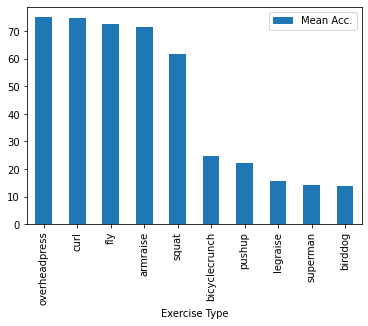

In [37]:
# plot accuracy per exercise type

#xlabels = list(df1_folders['ex_name'])
#print(xlabels)

sorted_results_per_folder_1_0_vis_all_df.plot(x='Exercise Type', y="Mean Acc.", kind="bar")
plt.show()

# EXP1b: Lightning, PDJ@0.2, v=None(all keypoints)

In [38]:
results_global_mean_0_2_vis_all, results_per_folder_0_2_vis_all, results_per_vid_0_2_vis_all = video_folder_predictions(actual_directory, 'pdj', 0.2, visibility=None)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 0.0
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 0.6808278867102395
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
<class 'str'>
000002
VIDEO 

KeyboardInterrupt: 

# EXP2: Lightning, PDJ@1.0, v=2 (in frame & unoccluded)

In [ ]:
results_global_mean_1_0_vis_2, results_per_folder_1_0_vis_2, results_per_vid_1_0_vis_2 = video_folder_predictions(actual_directory, 'pdj', 1, 2)

In [ ]:
print( 'global mean: ', results_global_mean_1_0_vis_2 )
print()

# create dataframe [1] for each video and [2] for each folder.

# create DF of video accuracies TO get unique ex_names
results_per_vid_1_0_vis_2_df = pd.DataFrame(results_per_vid_1_0_vis_2)
print( 'DF1: ' )
display( results_per_vid_1_0_vis_2_df.head() )
print()
# make new dataframe with unique ex_names and accs per folder
df2_videos = pd.DataFrame(results_per_folder_1_0_vis_2)
results_per_folder_1_0_vis_2_df = pd.DataFrame({ 'Exercise Name' : df2_videos[0], 'Avg. Accuracy' : df2_videos[1] })
results_per_folder_1_0_vis_2_df = results_per_folder_1_0_vis_2_df.sort_values(by='Avg. Accuracy', ascending=False)
print( 'DF2: ' )
display( results_per_folder_1_0_vis_2_df )

In [ ]:
results_per_folder_1_0_vis_2_df.plot(x='Exercise Name', y="Avg. Accuracy", kind="bar")
plt.show()

# EXP2b: Lightning, PDJ@0.2, v=2 (in frame & unoccluded)

In [ ]:
results_global_mean_0_2_vis_2, results_per_folder_0_2_vis_2, results_per_vid_0_2_vis_2 = video_folder_predictions(actual_directory, 'pdj', 0.2, 2)

# EXP4: Lightning, PCK@1.0, vis=None (ALL keypoints)

In [ ]:
results_global_mean_pck_1_0_vis_all, results_per_folder_pck_1_0_vis_all, results_per_vid_pck_1_0_vis_all = video_folder_predictions(actual_directory, 'pck', 1)

In [ ]:
print( 'global mean: ', results_global_mean_pck_1_0_vis_all )

display( pd.DataFrame(results_per_folder_pck_1_0_vis_all) )

In [ ]:
print( 'global mean: ', results_global_mean_pck_1_0_vis_all )
print()

# create dataframe [1] for each video and [2] for each folder.

# create DF of video accuracies TO get unique ex_names
df3_videos = pd.DataFrame(results_per_vid_pck_1_0_vis_all)
print( 'DF1, per vid: ' )
display( df3_videos.head() )
print()
# make new dataframe with unique ex_names and accs per folder
df3_videos = pd.DataFrame( results_per_folder_pck_1_0_vis_all )
results_per_folder_pck_1_0_vis_all = pd.DataFrame({ 'Exercise Name' : df3_videos[0], 'Avg. Accuracy' : df3_videos[1] })
df3_folders = results_per_folder_pck_1_0_vis_all.sort_values(by='Avg. Accuracy', ascending=False)
print( 'DF2, per ex type: ' )
display( df3_folders )

In [ ]:
df3_folders.plot(x='Exercise Name', y="Avg. Accuracy", kind="bar")
plt.show()

# EXP4b: Lightning, PCK@0.2, vis=None (ALL keypoints)

In [ ]:
results_global_mean_pck_0_2_vis_all, results_per_folder_pck_0_2_vis_all, results_per_vid_pck_0_2_vis_all = video_folder_predictions(actual_directory, 'pck', 0.2)

# EXP5: Lightning, PCK@1.0, vis=2 (in frame & unoccluded)

In [39]:
results_global_mean_pck_1_0_vis_2, results_per_folder_pck_1_0_vis_2, results_per_vid_pck_1_0_vis_2 = video_folder_predictions(actual_directory, 'pck', 1, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

In [40]:
print( 'global mean: ', results_global_mean_pck_1_0_vis_2 )
print()

# create dataframe [1] for each video and [2] for each folder.

# create DF of video accuracies TO get unique ex_names
results_per_vid_pck_1_0_vis_2_df = pd.DataFrame(results_per_vid_pck_1_0_vis_2)
print( 'DF1, per vid: ' )
display( results_per_vid_pck_1_0_vis_2_df.head() )
print()
# make new dataframe with unique ex_names and accs per folder
df4_videos = pd.DataFrame( results_per_folder_pck_1_0_vis_2 )
results_per_folder_pck_1_0_vis_2_df = pd.DataFrame({ 'Exercise Name' : df4_videos[0], 'Avg. Accuracy' : df4_videos[1] })
results_per_folder_pck_1_0_vis_2_df = results_per_folder_pck_1_0_vis_2_df.sort_values(by='Avg. Accuracy', ascending=False)
print( 'DF2, per ex type: ' )
display( results_per_folder_pck_1_0_vis_2_df )

global mean:  91.15906911804807

DF1, per vid: 


0       1      2
0  curl  000000  100.0
1  curl  000001  100.0
2  curl  000002  100.0
3  curl  000003  100.0
4  curl  000004  100.0


DF2, per ex type: 


Exercise Name  Avg. Accuracy
1       armraise      99.998236
3  overheadpress      99.801990
9          squat      99.720952
7            fly      99.217327
0           curl      97.998624
4        birddog      87.390695
6         pushup      84.601723
5       superman      82.851874
8  bicyclecrunch      81.268327
2       legraise      78.740943

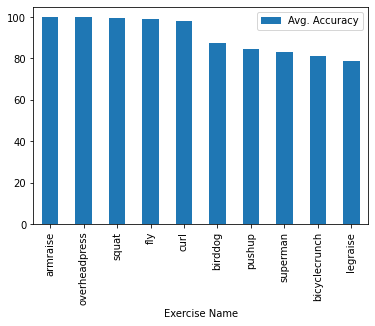

In [41]:
results_per_folder_pck_1_0_vis_2_df.plot(x='Exercise Name', y="Avg. Accuracy", kind="bar")
plt.show()

# EXP5b:Lightning, PCK@0.2, vis=2 (in frame & unoccluded)

In [42]:
results_global_mean_pck_0_2_vis_2, results_per_folder_pck_0_2_vis_2, results_per_vid_pck_0_2_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.2, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 54.76421929718634
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 45.206552706552706
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
<class 'str'>

# EXP5c:Lightning, PCK@0.3, vis=2 (in frame & unoccluded)

In [43]:
results_global_mean_pck_0_3_vis_2, results_per_folder_pck_0_3_vis_2, results_per_vid_pck_0_3_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.3, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 99.83385661957091
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 68.65724553224553
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>


# EXP5d:Lightning, PCK@0.4, vis=2 (in frame & unoccluded)

In [44]:
results_global_mean_pck_0_4_vis_2, results_per_folder_pck_0_4_vis_2, results_per_vid_pck_0_4_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.4, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 90.87617629284296
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000002
VIDEO

# EXP5e:Lightning, PCK@0.5, vis=2 (in frame & unoccluded)

In [45]:
results_global_mean_pck_0_5_vis_2, results_per_folder_pck_0_5_vis_2, results_per_vid_pck_0_5_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.5, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 99.54594017094017
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000002
VIDEO

# EXP5f:Lightning, PCK@0.6, vis=2 (in frame & unoccluded)

In [46]:
results_global_mean_pck_0_6_vis_2, results_per_folder_pck_0_6_vis_2, results_per_vid_pck_0_6_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.6, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

# EXP5g:Lightning, PCK@0.7, vis=2 (in frame & unoccluded)

In [47]:
results_global_mean_pck_0_7_vis_2, results_per_folder_pck_0_7_vis_2, results_per_vid_pck_0_7_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.7, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

# EXP5h:Lightning, PCK@0.8, vis=2 (in frame & unoccluded)

In [48]:
results_global_mean_pck_0_8_vis_2, results_per_folder_pck_0_8_vis_2, results_per_vid_pck_0_8_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.8, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

# EXP5i:Lightning, PCK@0.9, vis=2 (in frame & unoccluded)

In [49]:
results_global_mean_pck_0_9_vis_2, results_per_folder_pck_0_9_vis_2, results_per_vid_pck_0_9_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.9, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

# EXP5j:Lightning, PCK@0.1, vis=2 (in frame & unoccluded)

In [50]:
results_global_mean_pck_0_1_vis_2, results_per_folder_pck_0_1_vis_2, results_per_vid_pck_0_1_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.1, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 0.25641025641025644
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 1.8340455840455843
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
<class 'str

# Create DF for each video

In [51]:
# with DF containing accuracy per video (unique to each experiment)
df_per_video = pd.DataFrame(   )

# create DF containing metadata per video in following folders:


curl_folder = "InfinityAI Data/infinityai_fitness_basic_curl_v1.0"
armraise_folder = "InfinityAI Data/infinityai_fitness_basic_armraise_v1.0"
legraise_folder = "InfinityAI Data/infinityai_fitness_basic_legraise_v1.0"
overheadpress_folder = "InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0"
birddog_folder = "InfinityAI Data/infinityai_fitness_basic_birddog_v1.0"
superman_folder = "InfinityAI Data/infinityai_fitness_basic_superman_v1.0"
pushup_folder = "InfinityAI Data/infinityai_fitness_basic_pushup_v1.0"
basic_fly_folder = "InfinityAI Data/infinityai_fitness_basic_fly_v1.0"
bicyclecrunch_folder = "InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0"
squat_folder = "InfinityAI Data/infinityai_fitness_basic_squat_v1.0"

sub_folders = [ curl_folder, armraise_folder, legraise_folder, overheadpress_folder, birddog_folder, 
           superman_folder, pushup_folder, basic_fly_folder, bicyclecrunch_folder, squat_folder ]

In [52]:
# metadata per video

def meta_per_video(folder):
    
    metadata = []
    
    for sub_folders in folder:
    
        # iterate over annotation jsons for each video and extract labels
        json_paths = sorted(glob.glob(os.path.join(sub_folders, "*.json")))

        for json_path in json_paths:

            ex_name = json_path.split("/")[-2]
            ex_name = ex_name.split("_")[-2]

            ex_num = json_path.split(".")[-2]
            ex_num = ex_num.split("/")[-1]

            coco = COCO(json_path)
            percent_in_fov = []
            percent_occlusion = []
            for ann in coco.anns.values():
                if coco.cats[ann["category_id"]]["name"] != "person":
                    # skip any non-person annotations (e.g. for dumbbells)
                    continue
                percent_in_fov.append(ann["percent_in_fov"])
                percent_occlusion.append(ann["percent_occlusion"])
            avg_percent_in_fov = np.mean(percent_in_fov)  # average across frames
            avg_percent_occlusion = np.mean(percent_occlusion)  # average across frames
            metadata.append({
                            "ex_name": ex_name,
                            "video_number": coco.dataset["info"]["video_number"],
                            "avg_percent_in_fov": avg_percent_in_fov,
                            "avg_percent_occlusion": avg_percent_occlusion,
                            "camera_height": coco.dataset["info"]["camera_height"],
                            "camera_pitch": coco.dataset["info"]["camera_pitch"],
                            })               
    
    metadata_df = pd.DataFrame(metadata)

    return metadata_df


metadata_full = meta_per_video(sub_folders)
clear_output()
print('Done')

Done


In [53]:
#pprint(metadata_full)

display(metadata_full)

ex_name  video_number  avg_percent_in_fov  avg_percent_occlusion  \
0      curl             0           95.901492               2.642545   
1      curl             1          100.000000              11.840264   
2      curl             2          100.000000               2.664757   
3      curl             3          100.000000               1.992999   
4      curl             4           99.744104               4.424402   
..      ...           ...                 ...                    ...   
994   squat            95           98.400702               0.000000   
995   squat            96           97.998026               0.009473   
996   squat            97          100.000000               2.675084   
997   squat            98          100.000000               0.093388   
998   squat            99           99.154815               0.025417   

     camera_height  camera_pitch  
0         1.477322     87.239855  
1         0.847416     95.694468  
2         1.790054     84.172874  
3         1.917482     79.964897  
4         1.481914     85.833956  
..             ...           ...  
994       1.781202     81.234117  
995       0.974657     93.996182  
996       0.927425     93.705865  
997       1.841079     80.624496  
998       1.871776     79.684860  

[999 rows x 6 columns]

In [54]:
### NOW USE THIS DATAFRAME TO CALCULATE ACCUARACY CONSIDERING ONLY VIDEOS WITH 100% FOV AND <X% OCCLUSION
### DETERMINE X% OCCLUSION BY PLOTTING IT AND SELECTING

# DF Append w. Accuracies

In [55]:
# simple add column with list of results as new column - visually inspect column for errors

#metadata_full["Exp_1"] = pd.DataFrame(results_per_vid_1_0_vis_all)[2]
#metadata_full["Exp_1b"] = pd.DataFrame(results_per_vid_0_2_vis_all)[2]
#metadata_full["Exp_2"] = pd.DataFrame(results_per_vid_1_0_vis_2)[2]
#metadata_full["Exp_2b"] = pd.DataFrame(results_per_vid_0_2_vis_2)[2]
#metadata_full["Exp_4"] = pd.DataFrame(results_per_vid_pck_1_0_vis_all)[2]
#metadata_full["Exp_4b"] = pd.DataFrame(results_per_vid_pck_0_2_vis_all)[2]



In [56]:
metadata_full["0.1"] = pd.DataFrame(results_per_vid_pck_0_1_vis_2)[2]
metadata_full["0.2"] = pd.DataFrame(results_per_vid_pck_0_2_vis_2)[2]
metadata_full["0.3"] = pd.DataFrame(results_per_vid_pck_0_3_vis_2)[2]
metadata_full["0.4"] = pd.DataFrame(results_per_vid_pck_0_4_vis_2)[2]
metadata_full["0.5"] = pd.DataFrame(results_per_vid_pck_0_5_vis_2)[2]
metadata_full["0.6"] = pd.DataFrame(results_per_vid_pck_0_6_vis_2)[2]
metadata_full["0.7"] = pd.DataFrame(results_per_vid_pck_0_7_vis_2)[2]
metadata_full["0.8"] = pd.DataFrame(results_per_vid_pck_0_8_vis_2)[2]
metadata_full["0.9"] = pd.DataFrame(results_per_vid_pck_0_9_vis_2)[2]
metadata_full["1.0"] = pd.DataFrame(results_per_vid_pck_1_0_vis_2)[2]

In [57]:
pd.set_option('display.max_rows', None)
display(metadata_full[:])

ex_name  video_number  avg_percent_in_fov  avg_percent_occlusion  \
0             curl             0           95.901492               2.642545   
1             curl             1          100.000000              11.840264   
2             curl             2          100.000000               2.664757   
3             curl             3          100.000000               1.992999   
4             curl             4           99.744104               4.424402   
5             curl             5           94.199886               2.550902   
6             curl             6           98.968708               1.970541   
7             curl             7          100.000000               3.462163   
8             curl             8           89.587804               2.370963   
9             curl             9          100.000000              16.948765   
10            curl            10          100.000000               2.644054   
11            curl            11           93.759050               2.454222   
12            curl            12          100.000000              96.489086   
13            curl            13           94.715598               3.323321   
14            curl            14          100.000000               2.383347   
15            curl            15          100.000000               1.926323   
16            curl            16          100.000000               3.562261   
17            curl            17          100.000000               3.334287   
18            curl            18           98.252418               2.712220   
19            curl            19           98.231419               4.572685   
20            curl            20           95.100901               2.689407   
21            curl            21          100.000000               2.793964   
22            curl            22          100.000000               2.232001   
23            curl            23          100.000000               3.414503   
24            curl            24           96.190931               3.599022   
25            curl            25          100.000000               3.778224   
26            curl            26          100.000000               3.772998   
27            curl            27          100.000000               3.273214   
28            curl            28          100.000000              59.947629   
29            curl            29          100.000000               3.025386   
30            curl            30           97.890002               3.764236   
31            curl            31          100.000000               2.852666   
32            curl            32          100.000000               3.637314   
33            curl            33          100.000000               3.582896   
34            curl            34          100.000000               3.737622   
35            curl            35          100.000000               4.276199   
36            curl            36          100.000000               3.168427   
37            curl            37           94.959935               1.954590   
38            curl            38           93.999750               2.591131   
39            curl            39           93.627597               3.202952   
40            curl            40          100.000000               2.930444   
41            curl            41           98.878470               3.370989   
42            curl            42          100.000000               1.736757   
43            curl            43           96.710136               2.434051   
44            curl            44           99.486184               2.064449   
45            curl            45           95.807117               2.493004   
46            curl            46          100.000000               3.286782   
47            curl            47          100.000000               1.953673   
48            curl            48          100.000000               4.724502   
49            curl            49          100.000000         

In [60]:
# save DF to CSV

metadata_full.to_csv('lightning_meta_results.csv', index=False)

In [118]:
# import CSV and test
df = pd.read_csv('lightning_meta_results.csv')
display(df[:3])

ex_name  video_number  avg_percent_in_fov  avg_percent_occlusion  \
0    curl             0           95.901492               2.642545   
1    curl             1          100.000000              11.840264   
2    curl             2          100.000000               2.664757   

   camera_height  camera_pitch       0.1        0.2        0.3         0.4  \
0       1.477322     87.239855  0.256410  54.764219  99.833857  100.000000   
1       0.847416     95.694468  1.834046  45.206553  68.657246   90.876176   
2       1.790054     84.172874  0.000000   8.500945  98.882291   99.484224   

          0.5       0.6    0.7    0.8    0.9    1.0  
0  100.000000  100.0000  100.0  100.0  100.0  100.0  
1   99.545940  100.0000  100.0  100.0  100.0  100.0  
2   99.833508   99.9185  100.0  100.0  100.0  100.0

<class 'numpy.ndarray'>


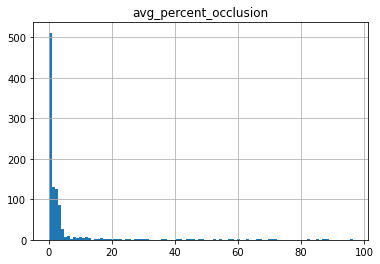

In [119]:
# plot fov to get a feel for best cutoff

ax_occ = df.hist("avg_percent_occlusion", bins=100)
#ax_occ.set_xlabel('Avg. Percentage Occlusion (%)')
#ax_occ.set_ylabel('Video Count')

print(type(ax_occ))

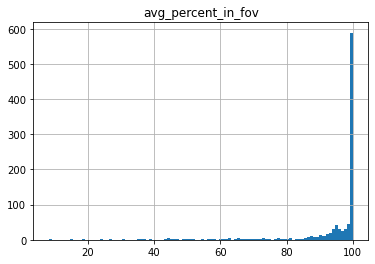

In [120]:
ax_fov = df.hist("avg_percent_in_fov", bins=100)
#ax_fov.set_xlabel('Avg. In Field-of-View (%)')
#ax_fov.set_ylabel('Video Count')

In [121]:
# create new DF with rows that meet chosen criteria [FOV = 100%, OCC <2%],
# this will then be used to calc new mean and plot for chosen criteria

df_5 = df[df["avg_percent_in_fov"] > 95]
df_5 = df_5[df_5["avg_percent_occlusion"] < 5]

print(df_5.shape)

display(df_5)

(633, 16)


ex_name  video_number  avg_percent_in_fov  avg_percent_occlusion  \
0             curl             0           95.901492               2.642545   
2             curl             2          100.000000               2.664757   
3             curl             3          100.000000               1.992999   
4             curl             4           99.744104               4.424402   
6             curl             6           98.968708               1.970541   
7             curl             7          100.000000               3.462163   
10            curl            10          100.000000               2.644054   
14            curl            14          100.000000               2.383347   
15            curl            15          100.000000               1.926323   
16            curl            16          100.000000               3.562261   
17            curl            17          100.000000               3.334287   
18            curl            18           98.252418               2.712220   
19            curl            19           98.231419               4.572685   
20            curl            20           95.100901               2.689407   
21            curl            21          100.000000               2.793964   
22            curl            22          100.000000               2.232001   
23            curl            23          100.000000               3.414503   
24            curl            24           96.190931               3.599022   
25            curl            25          100.000000               3.778224   
26            curl            26          100.000000               3.772998   
27            curl            27          100.000000               3.273214   
29            curl            29          100.000000               3.025386   
30            curl            30           97.890002               3.764236   
31            curl            31          100.000000               2.852666   
32            curl            32          100.000000               3.637314   
33            curl            33          100.000000               3.582896   
34            curl            34          100.000000               3.737622   
35            curl            35          100.000000               4.276199   
36            curl            36          100.000000               3.168427   
40            curl            40          100.000000               2.930444   
41            curl            41           98.878470               3.370989   
42            curl            42          100.000000               1.736757   
43            curl            43           96.710136               2.434051   
44            curl            44           99.486184               2.064449   
45            curl            45           95.807117               2.493004   
46            curl            46          100.000000               3.286782   
47            curl            47          100.000000               1.953673   
48            curl            48          100.000000               4.724502   
50            curl            50           99.997872               3.542684   
52            curl            52           98.834601               3.109755   
53            curl            53          100.000000               2.236460   
54            curl            54           98.047054               3.806970   
55            curl            55          100.000000               3.627179   
56            curl            56          100.000000               4.016376   
57            curl            57           96.009713               3.550775   
58            curl            58          100.000000               3.570947   
61            curl            61          100.000000               3.434188   
62            curl            62           98.504546               3.061984   
64            curl            64          100.000000               3.689382   
65            curl            65          100.000000         

In [122]:
df_5_clean = df_5.drop( columns=['avg_percent_in_fov', 'avg_percent_occlusion', 'camera_height', 'camera_pitch'] )
display(df_5_clean)

ex_name  video_number        0.1         0.2         0.3  \
0             curl             0   0.256410   54.764219   99.833857   
2             curl             2   0.000000    8.500945   98.882291   
3             curl             3   0.082692   67.131451   98.168718   
4             curl             4   7.336057   40.384285   80.935124   
6             curl             6   1.954650   72.317593   97.326092   
7             curl             7   0.000000    9.969005   85.873407   
10            curl            10  25.130911   77.524783   98.578693   
14            curl            14   7.039862   66.159801   92.912984   
15            curl            15   1.349206   61.947312   97.835498   
16            curl            16   0.000000    8.912245   39.844375   
17            curl            17   0.103134   33.433524   99.493997   
18            curl            18   2.124271   66.245693   97.571768   
19            curl            19   0.094563   58.208440   98.886551   
20            curl            20   2.414008   74.911853   95.394556   
21            curl            21   5.781375   53.676715   89.552604   
22            curl            22   2.652738   63.850043   93.975444   
23            curl            23   0.000000   65.618833  100.000000   
24            curl            24  21.936397   73.678076   98.697355   
25            curl            25   0.305677    9.414319   42.691508   
26            curl            26   2.040816   16.113198   55.892624   
27            curl            27   1.622172   50.114429   90.023224   
29            curl            29   6.307411   76.883954   98.962384   
30            curl            30   3.945559   60.187099   90.712788   
31            curl            31   0.000000   41.209748   82.271336   
32            curl            32   0.242684   49.785397   87.967543   
33            curl            33   0.283757   69.685718   99.863014   
34            curl            34   1.262745   41.805128   82.912648   
35            curl            35   0.000000   14.574936   69.051397   
36            curl            36   0.533584    2.368397   19.522671   
40            curl            40   0.262572   73.065797   98.015987   
41            curl            41   2.487221   66.304609   96.795596   
42            curl            42   0.970874   17.744674   81.943081   
43            curl            43   4.779788   43.331519   73.757862   
44            curl            44   0.000000   67.117216  100.000000   
45            curl            45   2.996435   42.379065  100.000000   
46            curl            46  12.092491   66.854757   97.547354   
47            curl            47  11.202619   68.446342   96.159297   
48            curl            48   1.614368   14.034121   48.340956   
50            curl            50   5.259288   84.772894  100.000000   
52            curl            52  12.982739   79.735124   99.248232   
53            curl            53   0.028369   30.910919   83.147689   
54            curl            54  29.961958   89.986672  100.000000   
55            curl            55   0.136054   31.498841   85.580025   
56            curl            56   0.046382    2.776351   82.830225   
57            curl            57   0.283473   79.433647   99.945328   
58            curl            58   0.946197    4.462442   54.466169   
61            curl            61   0.000000    0.678397   35.531592   
62            curl            62   0.746077   70.599857  100.000000   
64            curl            64   0.000000    3.406762   59.902770   
65            curl            65   0.246914   61.703852   96.602533   
68            curl            68   0.000000    0.052013    4.854618   
69            curl            69   0.000000   85.841823  100.000000   
70            curl            70  18.689703   81.162230  100.000000   
71            curl            71  18.532299   82.424213   99.936414   
72            curl            72   1.338405   40.365636   92.595682   
75            curl            75   

In [123]:
df_5_plot = df_5_clean.drop(columns='video_number')
display(df_5_plot.head())

ex_name       0.1        0.2        0.3         0.4         0.5       0.6  \
0    curl  0.256410  54.764219  99.833857  100.000000  100.000000  100.0000   
2    curl  0.000000   8.500945  98.882291   99.484224   99.833508   99.9185   
3    curl  0.082692  67.131451  98.168718   99.432563  100.000000  100.0000   
4    curl  7.336057  40.384285  80.935124   97.137700  100.000000  100.0000   
6    curl  1.954650  72.317593  97.326092  100.000000  100.000000  100.0000   

     0.7    0.8    0.9    1.0  
0  100.0  100.0  100.0  100.0  
2  100.0  100.0  100.0  100.0  
3  100.0  100.0  100.0  100.0  
4  100.0  100.0  100.0  100.0  
6  100.0  100.0  100.0  100.0

<AxesSubplot:>

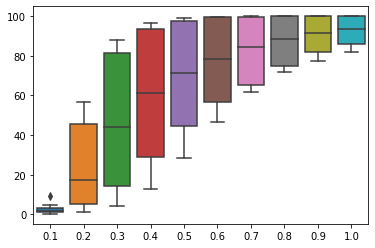

In [133]:
sns.boxplot(data=df_5_plot.groupby('ex_name').mean())

In [101]:
#ex_names = df_5_plot['ex_name'].unique()

df_5_plot = df_5_plot.groupby('ex_name').mean().round(2)
display(df_5_plot)

0.1    0.2    0.3    0.4    0.5    0.6    0.7     0.8     0.9  \
ex_name                                                                         
armraise       2.14  37.20  78.62  92.77  97.98  99.64  99.98   99.99   99.99   
bicyclecrunch  1.23   5.10  13.44  27.89  44.10  58.94  69.71   77.31   82.57   
birddog        0.27   1.18   4.26  12.90  29.32  46.51  61.91   73.12   81.45   
curl           3.78  48.10  85.58  95.31  98.76  99.70  99.94  100.00  100.00   
fly            4.67  49.43  82.71  93.54  97.37  99.14  99.64   99.67   99.68   
legraise       1.41   6.36  16.62  31.12  45.27  55.78  64.66   71.68   77.27   
overheadpress  9.00  56.58  87.95  96.80  99.31  99.76  99.94   99.97   99.98   
pushup         0.21   1.17   4.32  13.34  28.62  47.47  63.75   75.47   83.35   
squat          1.65  26.77  64.84  84.71  93.59  97.64  99.24   99.76   99.88   
superman       1.94   8.07  23.01  38.11  49.50  59.34  67.84   74.78   79.68   

                  1.0  
ex_name                
armraise       100.00  
bicyclecrunch   85.99  
birddog         86.55  
curl           100.00  
fly             99.71  
legraise        81.85  
overheadpress  100.00  
pushup          87.49  
squat           99.93  
superman        83.42

In [102]:
# save DF to CSV

df_5_plot.to_csv('lightning_data_per_ex.csv', index=True)

In [174]:
# import CSV and test
df_5_plot = pd.read_csv('lightning_data_per_ex.csv', index_col=0)
display(df[:3])

ex_name  video_number  avg_percent_in_fov  avg_percent_occlusion  \
0    curl             0           95.901492               2.642545   
1    curl             1          100.000000              11.840264   
2    curl             2          100.000000               2.664757   

   camera_height  camera_pitch       0.1        0.2        0.3         0.4  \
0       1.477322     87.239855  0.256410  54.764219  99.833857  100.000000   
1       0.847416     95.694468  1.834046  45.206553  68.657246   90.876176   
2       1.790054     84.172874  0.000000   8.500945  98.882291   99.484224   

          0.5       0.6    0.7    0.8    0.9    1.0  
0  100.000000  100.0000  100.0  100.0  100.0  100.0  
1   99.545940  100.0000  100.0  100.0  100.0  100.0  
2   99.833508   99.9185  100.0  100.0  100.0  100.0

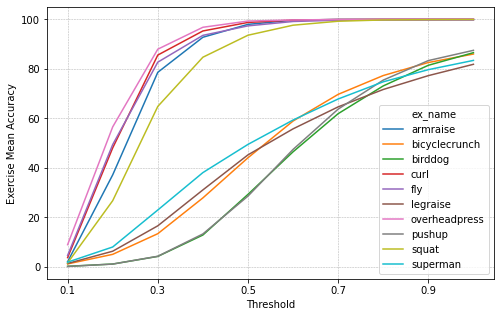

In [175]:
ax = df_5_plot.T.plot(figsize=(8,5))
ax.set_xlabel('Threshold')
ax.set_ylabel('Exercise Mean Accuracy')
ax.grid(linestyle='--', linewidth=0.5)

# try seaborn first, might resolve the followign automatically
# move legend
# include all x axis labels, and potential verical dashed lines
# plot histogram of average of each exercise to clearly show which exercises

In [176]:
# add column of means
df_5_plot['mean'] = list(df_5_plot.mean(axis=1))
df_5_plot['std'] = list(df_5_plot.std(axis=1))
display(df_5_plot)

0.1    0.2    0.3    0.4    0.5    0.6    0.7     0.8     0.9  \
ex_name                                                                         
armraise       2.14  37.20  78.62  92.77  97.98  99.64  99.98   99.99   99.99   
bicyclecrunch  1.23   5.10  13.44  27.89  44.10  58.94  69.71   77.31   82.57   
birddog        0.27   1.18   4.26  12.90  29.32  46.51  61.91   73.12   81.45   
curl           3.78  48.10  85.58  95.31  98.76  99.70  99.94  100.00  100.00   
fly            4.67  49.43  82.71  93.54  97.37  99.14  99.64   99.67   99.68   
legraise       1.41   6.36  16.62  31.12  45.27  55.78  64.66   71.68   77.27   
overheadpress  9.00  56.58  87.95  96.80  99.31  99.76  99.94   99.97   99.98   
pushup         0.21   1.17   4.32  13.34  28.62  47.47  63.75   75.47   83.35   
squat          1.65  26.77  64.84  84.71  93.59  97.64  99.24   99.76   99.88   
superman       1.94   8.07  23.01  38.11  49.50  59.34  67.84   74.78   79.68   

                  1.0    mean        std  
ex_name                                   
armraise       100.00  80.831  32.186180  
bicyclecrunch   85.99  46.628  31.163189  
birddog         86.55  39.747  32.733794  
curl           100.00  83.117  30.550131  
fly             99.71  82.556  29.918154  
legraise        81.85  45.202  28.292584  
overheadpress  100.00  84.929  28.374156  
pushup          87.49  40.519  33.487533  
squat           99.93  76.801  33.422659  
superman        83.42  48.569  28.168851

Text(0.5, 0, 'Exercise Mean Accuracy')

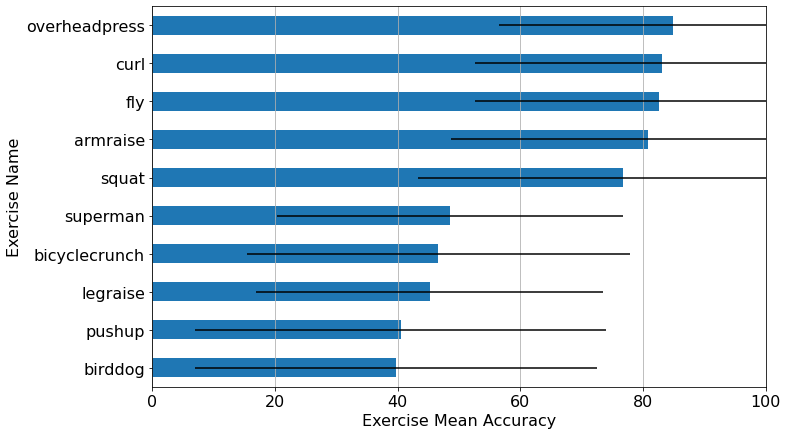

In [204]:
y_err = list(df_5_plot["std"])

ax2 = df_5_plot['mean'].sort_values().plot.barh(figsize=(11,7), xerr=y_err, xlim=(0,100), fontsize=16)
ax2.grid(axis='x')
ax2.set_ylabel('Exercise Name', fontdict={'fontsize':16})
ax2.set_xlabel('Exercise Mean Accuracy', fontdict={'fontsize':16})
#ax2.title('Mean Accuracy Per Exercise for All Thresholds')

<AxesSubplot:>

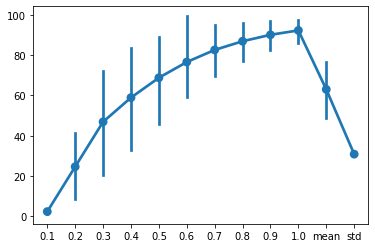

In [181]:
sns.pointplot(data=df_5_plot[:"mean"])

In [182]:
full_mean = df_5_plot['mean'].mean()
print(full_mean)

62.8899


In [183]:
for thresh in df_5_plot.columns:
    print(str(thresh)+" mean: ", round(df_5_plot[thresh].mean(), 2))
    print(str(thresh)+" std: ", round(df_5_plot[thresh].std(), 2))

0.1 mean:  2.63
0.1 std:  2.64
0.2 mean:  24.0
0.2 std:  22.2
0.3 mean:  46.14
0.3 std:  36.55
0.4 mean:  58.65
0.4 std:  36.72
0.5 mean:  68.38
0.5 std:  31.3
0.6 mean:  76.39
0.6 std:  24.38
0.7 mean:  82.66
0.7 std:  18.13
0.8 mean:  87.17
0.8 std:  13.47
0.9 mean:  90.39
0.9 std:  10.17
1.0 mean:  92.49
1.0 std:  7.99
mean mean:  62.89
mean std:  20.04
std mean:  30.83
std std:  2.1


In [184]:
mean_th = []
std_th = []

for thresh in df_5_plot.columns:
    mean_th.append(df_5_plot[thresh].mean())
    std_th.append(df_5_plot[thresh].std())

df_mean_th = pd.DataFrame({"mean_th" : mean_th})
df_std_th = pd.DataFrame({"std_th": std_th})

In [185]:
df_5_plot = df_5_plot.sort_values('mean')
display(df_5_plot)

0.1    0.2    0.3    0.4    0.5    0.6    0.7     0.8     0.9  \
ex_name                                                                         
birddog        0.27   1.18   4.26  12.90  29.32  46.51  61.91   73.12   81.45   
pushup         0.21   1.17   4.32  13.34  28.62  47.47  63.75   75.47   83.35   
legraise       1.41   6.36  16.62  31.12  45.27  55.78  64.66   71.68   77.27   
bicyclecrunch  1.23   5.10  13.44  27.89  44.10  58.94  69.71   77.31   82.57   
superman       1.94   8.07  23.01  38.11  49.50  59.34  67.84   74.78   79.68   
squat          1.65  26.77  64.84  84.71  93.59  97.64  99.24   99.76   99.88   
armraise       2.14  37.20  78.62  92.77  97.98  99.64  99.98   99.99   99.99   
fly            4.67  49.43  82.71  93.54  97.37  99.14  99.64   99.67   99.68   
curl           3.78  48.10  85.58  95.31  98.76  99.70  99.94  100.00  100.00   
overheadpress  9.00  56.58  87.95  96.80  99.31  99.76  99.94   99.97   99.98   

                  1.0    mean        std  
ex_name                                   
birddog         86.55  39.747  32.733794  
pushup          87.49  40.519  33.487533  
legraise        81.85  45.202  28.292584  
bicyclecrunch   85.99  46.628  31.163189  
superman        83.42  48.569  28.168851  
squat           99.93  76.801  33.422659  
armraise       100.00  80.831  32.186180  
fly             99.71  82.556  29.918154  
curl           100.00  83.117  30.550131  
overheadpress  100.00  84.929  28.374156

In [186]:
df_hoz = df_5_plot['pushup':'superman']

hoz_mean = df_hoz['mean'].mean()
print('hoz mean: ', hoz_mean)

hoz_thresh_mean = []

for thresh in df_hoz.columns:
    hoz_thresh_mean.append(round(df_hoz[thresh].mean(), 2))
    
print(hoz_thresh_mean)

#df_hoz.loc('mean') = hoz_thresh_mean

display(df_hoz)

hoz mean:  45.2295
[1.2, 5.17, 14.35, 27.61, 41.87, 55.38, 66.49, 74.81, 80.72, 84.69, 45.23, 30.28]


0.1   0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9  \
ex_name                                                                      
pushup         0.21  1.17   4.32  13.34  28.62  47.47  63.75  75.47  83.35   
legraise       1.41  6.36  16.62  31.12  45.27  55.78  64.66  71.68  77.27   
bicyclecrunch  1.23  5.10  13.44  27.89  44.10  58.94  69.71  77.31  82.57   
superman       1.94  8.07  23.01  38.11  49.50  59.34  67.84  74.78  79.68   

                 1.0    mean        std  
ex_name                                  
pushup         87.49  40.519  33.487533  
legraise       81.85  45.202  28.292584  
bicyclecrunch  85.99  46.628  31.163189  
superman       83.42  48.569  28.168851

In [187]:
hoz_err = []

for thresh in df_hoz.columns:
    print(str(thresh)+" mean: ", round(df_hoz[thresh].mean(), 2))
    print(str(thresh)+" std: ", round(df_hoz[thresh].std(), 2))
    hoz_err.append(df_hoz[thresh].std())

0.1 mean:  1.2
0.1 std:  0.72
0.2 mean:  5.17
0.2 std:  2.93
0.3 mean:  14.35
0.3 std:  7.78
0.4 mean:  27.61
0.4 std:  10.43
0.5 mean:  41.87
0.5 std:  9.13
0.6 mean:  55.38
0.6 std:  5.51
0.7 mean:  66.49
0.7 std:  2.77
0.8 mean:  74.81
0.8 std:  2.34
0.9 mean:  80.72
0.9 std:  2.79
1.0 mean:  84.69
1.0 std:  2.53
mean mean:  45.23
mean std:  3.43
std mean:  30.28
std std:  2.55


In [188]:
df_vert = df_5_plot['squat':]
vert_mean = df_vert['mean'].mean()
print('vert mean: ', vert_mean)

vert_thresh_mean = []

for thresh in df_vert.columns:
    vert_thresh_mean.append(round(df_vert[thresh].mean(), 2))
    
print(vert_thresh_mean)

display(df_vert)

vert mean:  81.64680000000001
[4.25, 43.62, 79.94, 92.63, 97.4, 99.18, 99.75, 99.88, 99.91, 99.93, 81.65, 30.89]


0.1    0.2    0.3    0.4    0.5    0.6    0.7     0.8     0.9  \
ex_name                                                                         
squat          1.65  26.77  64.84  84.71  93.59  97.64  99.24   99.76   99.88   
armraise       2.14  37.20  78.62  92.77  97.98  99.64  99.98   99.99   99.99   
fly            4.67  49.43  82.71  93.54  97.37  99.14  99.64   99.67   99.68   
curl           3.78  48.10  85.58  95.31  98.76  99.70  99.94  100.00  100.00   
overheadpress  9.00  56.58  87.95  96.80  99.31  99.76  99.94   99.97   99.98   

                  1.0    mean        std  
ex_name                                   
squat           99.93  76.801  33.422659  
armraise       100.00  80.831  32.186180  
fly             99.71  82.556  29.918154  
curl           100.00  83.117  30.550131  
overheadpress  100.00  84.929  28.374156

In [189]:
vert_err = []

for thresh in df_vert.columns:
    print(str(thresh)+" mean: ", round(df_vert[thresh].mean(), 2))
    print(str(thresh)+" std: ", round(df_vert[thresh].std(), 2))
    vert_err.append(df_vert[thresh].std())

0.1 mean:  4.25
0.1 std:  2.92
0.2 mean:  43.62
0.2 std:  11.69
0.3 mean:  79.94
0.3 std:  9.13
0.4 mean:  92.63
0.4 std:  4.69
0.5 mean:  97.4
0.5 std:  2.26
0.6 mean:  99.18
0.6 std:  0.89
0.7 mean:  99.75
0.7 std:  0.32
0.8 mean:  99.88
0.8 std:  0.15
0.9 mean:  99.91
0.9 std:  0.14
1.0 mean:  99.93
1.0 std:  0.13
mean mean:  81.65
mean std:  3.08
std mean:  30.89
std std:  1.97


In [191]:
df_vert_hoz = pd.DataFrame( {'Horizontal': hoz_thresh_mean, 'Vertical': vert_thresh_mean} )
df_vert_hoz = df_vert_hoz.T
df_vert_hoz.columns = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', 'mean', 'std']

display(df_vert_hoz)

0.1    0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9  \
Horizontal  1.20   5.17  14.35  27.61  41.87  55.38  66.49  74.81  80.72   
Vertical    4.25  43.62  79.94  92.63  97.40  99.18  99.75  99.88  99.91   

              1.0   mean    std  
Horizontal  84.69  45.23  30.28  
Vertical    99.93  81.65  30.89

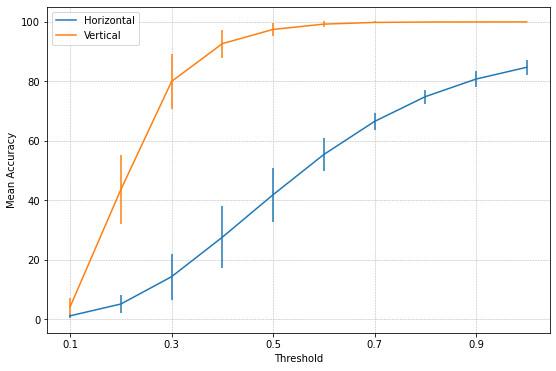

In [193]:
df_vert_hoz_plot = df_vert_hoz.loc[:, '0.1':'1.0']

ax = df_vert_hoz_plot.T.plot(figsize=(9,6), yerr=[hoz_err[:-2], vert_err[:-2]])
ax.set_xlabel('Threshold')
ax.set_ylabel('Mean Accuracy')
ax.grid(linestyle='--', linewidth=0.5)

<AxesSubplot:>

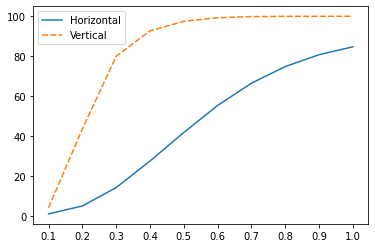

In [83]:
sns.lineplot(data=df_vert_hoz_plot.T)